In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00


In [3]:
! pip install transformers

In [4]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [5]:
! pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=d4dcb7c56298605febb9f4f19c581d4ce1fb153890f9f82794502dc24bf36d4c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [6]:
import gc
import re
import nltk
import torch
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.contrib import tzip
from tqdm.notebook import tqdm
from datasets import load_metric
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
rouge_metric = load_metric('rouge')

<ipython-input-8-90542a62301a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


In [9]:
class PegasusDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels['input_ids'][idx])  # torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels['input_ids'])  # len(self.labels)

In [10]:
def compute_metrics(pred_str, label_str):
    # labels_ids = pred.label_ids
    # pred_ids = pred.predictions

    # # all unnecessary tokens are removed
    # pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    # labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    # label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output1 = rouge_metric.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"].mid
    rouge_output2 = rouge_metric.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
    rouge_outputL = rouge_metric.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid

    return {
        "rouge1_precision": round(rouge_output1.precision, 4),
        "rouge1_recall": round(rouge_output1.recall, 4),
        "rouge1_fmeasure": round(rouge_output1.fmeasure, 4),
        "rouge2_precision": round(rouge_output2.precision, 4),
        "rouge2_recall": round(rouge_output2.recall, 4),
        "rouge2_fmeasure": round(rouge_output2.fmeasure, 4),
        "rougeL_precision": round(rouge_outputL.precision, 4),
        "rougeL_recall": round(rouge_outputL.recall, 4),
        "rougeL_fmeasure": round(rouge_outputL.fmeasure, 4),
    }

In [11]:
def compute_metrics_from_text(decoded_preds, decoded_labels):
  # Rouge expects a newline after each sentence
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

  result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  encoded_preds = tokenizer.encode(decoded_preds, skip_special_tokens=True)
  # Add mean generated length
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in encoded_preds]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

In [12]:
def compute_metrics_from_tokens(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  # Replace -100 in the labels as we can't decode them.
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Rouge expects a newline after each sentence
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

  result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  # Extract a few results
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  # Add mean generated length
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

In [13]:
def prepare_data(model_name,
                 train_texts, train_labels,
                 val_texts=None, val_labels=None,
                 test_texts=None, test_labels=None,
                 tokenizer = None,):
  """
  Prepare input data for model fine-tuning
  """
  tokenizer = PegasusTokenizer.from_pretrained(model_name)

  prepare_val = False if val_texts is None or val_labels is None else True
  prepare_test = False if test_texts is None or test_labels is None else True

  def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True)
    decodings = tokenizer(labels, truncation=True, padding=True)
    dataset_tokenized = PegasusDataset(encodings, decodings)
    return dataset_tokenized

  train_dataset = tokenize_data(train_texts, train_labels)
  val_dataset = tokenize_data(val_texts, val_labels) if prepare_val else None
  test_dataset = tokenize_data(test_texts, test_labels) if prepare_test else None

  return train_dataset, val_dataset, test_dataset, tokenizer

In [14]:
def prepare_fine_tuning(model_name, tokenizer, train_dataset, model = None, val_dataset=None, freeze_encoder=False, num_epochs = 1, output_dir='./results'):
  """
  Prepare configurations and base model for fine-tuning
  """
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  if model == None:
    model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)
  else:
    model = model.to(torch_device)

  if freeze_encoder:
    for param in model.model.encoder.parameters():
      param.requires_grad = False

  if val_dataset is not None:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      # num_train_epochs=2000,           # total number of training epochs
      num_train_epochs=num_epochs,           # total number of training epochs
      # per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      per_device_train_batch_size=10,   # batch size per device during training, can increase if memory allows
      # per_device_eval_batch_size=1,    # batch size for evaluation, can increase if memory allows
      per_device_eval_batch_size=1,    # batch size for evaluation, can increase if memory allows
      save_steps=250,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      evaluation_strategy='steps',     # evaluation strategy to adopt during training
      eval_steps=50,                  # number of update steps before evaluation
      warmup_steps=50,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=50,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      eval_dataset=val_dataset,            # evaluation dataset
      # data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics_from_tokens
    )

  else:
    training_args = TrainingArguments(
      output_dir=output_dir,           # output directory
      # num_train_epochs=2000,           # total number of training epochs
      num_train_epochs=num_epochs,           # total number of training epochs
      # per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      per_device_train_batch_size=1,   # batch size per device during training, can increase if memory allows
      save_steps=250,                  # number of updates steps before checkpoint saves
      save_total_limit=5,              # limit the total amount of checkpoints and deletes the older checkpoints
      warmup_steps=50,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
      logging_dir='./logs',            # directory for storing logs
      logging_steps=50,
    )

    trainer = Trainer(
      model=model,                         # the instantiated 🤗 Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset=train_dataset,         # training dataset
      # data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics_from_tokens
    )

  return trainer

In [15]:
# replacing many abbreviations and lower casing the words
def process_words(sentence):
  sentence = str(sentence).lower()
  sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
  sentence = re.sub(r"http\S+","",sentence)
  sentence = re.sub(r"there's", "there is", sentence)
  sentence = re.sub(r"i'm", "i am", sentence)
  sentence = re.sub(r"he's", "he is", sentence)
  sentence = re.sub(r"she's", "she is", sentence)
  sentence = re.sub(r"it's", "it is", sentence)
  sentence = re.sub(r"that's", "that is", sentence)
  sentence = re.sub(r"what's", "that is", sentence)
  sentence = re.sub(r"where's", "where is", sentence)
  sentence = re.sub(r"how's", "how is", sentence)
  sentence = re.sub(r"\'ll", " will", sentence)
  sentence = re.sub(r"\'ve", " have", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"\'d", " would", sentence)
  sentence = re.sub(r"\'re", " are", sentence)
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "can not", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"n'", "ng", sentence)
  sentence = re.sub(r"'bout", "about", sentence)
  sentence = re.sub(r"'til", "until", sentence)
  sentence = re.sub(r"\$", " usd ", sentence)
  sentence = re.sub(r"৳", " usd ", sentence)
  sentence = re.sub(r"₹", " inr ", sentence)
  sentence = re.sub(r"%", " percent", sentence)
  sentence = re.sub(r" & ", " and ", sentence)
  sentence = re.sub(r" &amp ", " and ", sentence)
  sentence = re.sub(r"&amp", "\&", sentence)
  sentence = re.sub(r",", "", sentence)
  sentence = re.sub(r"\"", "", sentence)
  sentence = re.sub(r"\'", "", sentence)
  sentence = re.sub(r' s ', "",sentence)
  sentence = re.sub(r"&#39", "", sentence) # the inshorts data has this in it
  sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
  sentence = re.sub(r"&#34", "", sentence) # the inshorts data has this in it
  sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
  sentence = re.sub(r"\\n", "", sentence)
  sentence = sentence.strip()
  return sentence

In [16]:
# remove unnecessary characters and transforming colloquial word to its common form
def clean_sentences(text):
  emoj = re.compile("["
    u"\U0001F600-\U0001F64F"    # emoticons
    u"\U0001F300-\U0001F5FF"    # symbols & pictographs
    u"\U0001F680-\U0001F6FF"    # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"    # flags (iOS)
    u"\U00002500-\U00002BEF"    # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"
    u"\u3030"
    "]+", re.UNICODE)

  text = text.lower()                                                             # make lowercase letters
  text = re.sub(emoj, '', text)                                                   # remove emoji
  text = re.sub(r'(.)\1{2,}', r'\1', text)                                        # change the repeated letters above 2 times to just 1
  text = re.sub("[\-_;:]", " ", text)                                            # remove -, _ and :
  text = re.sub("[¹²³¹⁰ⁱ⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾ⁿ]", "", text)                                 # remove power character
  text = re.sub(r"From|\S*@\S*\s?|Subject", "", text)                             # remove email starts
  text = re.sub("[^\w\s]*[_.!?#&;:><+-/)/(\'\"]", " ", text)                     # remove not string and whitespace
  text = re.sub("\s+", " ", text)                                                 # remove extra spaces
  text = re.sub(" +", " ", text.strip())                                          # Remove unnecessary white space
  return text

In [17]:
# list_stopwords = set(stopwords.words('english'))
# list_stopwords.remove('no')
# list_stopwords.remove('not')
# list_stopwords

In [18]:
# Eliminate stopwords and suffixes
def remove_stopwords(text):
  list_stopwords = set(stopwords.words('english'))                            # stopword from nltk
  list_stopwords.remove('no')                                                 # remove 'no' and 'no' from list_stopwords
  list_stopwords.remove('not')
  text = " ".join(w if w not in list_stopwords else '' for w in text.split())
  text = re.sub(" +", " ", text.strip())                                      # Remove unnecessary white space
  return text

In [19]:
def clean_text(text):
  text = process_words(text)
  text = clean_sentences(text)
  text = remove_stopwords(text)
  text = text.strip()
  return text

In [20]:
def clean_df(df, col_name):
  df[col_name] = df[col_name].apply(process_words)
  df[col_name] = df[col_name].apply(clean_sentences)
  df[col_name] = df[col_name].apply(remove_stopwords)
  df[col_name] = df[col_name].apply(lambda x: x.strip())

  return df

In [21]:
df_news_raw = pd.read_excel('https://github.com/ruhan-islam/text-summarizer/blob/main/dataset/news_data.xlsx?raw=true')

In [22]:
# display(HTML(df_news_raw.sample(3).to_html()))

In [23]:
df_news_raw.iloc[:, 0] = df_news_raw.iloc[:, 0].str.replace('&#34;', '\'')
df_news_raw.iloc[:, 0] = df_news_raw.iloc[:, 0].str.replace('&#39;', '\'')
df_news_raw.iloc[:, 0] = df_news_raw.iloc[:, 0].str.replace('&amp;', '&')

In [24]:
df_news_raw.iloc[:, 1] = df_news_raw.iloc[:, 1].str.replace('&#34;', '\'')
df_news_raw.iloc[:, 1] = df_news_raw.iloc[:, 1].str.replace('&#39;', '\'')
df_news_raw.iloc[:, 1] = df_news_raw.iloc[:, 1].str.replace('&amp;', '&')

In [25]:
# df_news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
df_news = df_news_raw[['short', 'long']]

In [26]:
# display(HTML(df_news.sample(3).to_html()))

In [27]:
# df_news = clean_df(df_news, 'long')

In [28]:
# data_idx = 45885
# print(df_news.iloc[data_idx]['short'])
# print(df_news.iloc[data_idx]['long'])


In [29]:
# data_idx = 24443
# print(df_news.iloc[data_idx]['short'])
# print(df_news.iloc[data_idx]['long'])


In [30]:
# data_idx = 45885
# print(df_news_raw.iloc[data_idx]['short'])
# print(df_news_raw.iloc[data_idx]['long'])

In [31]:
# display(HTML(df_news.sample(3).to_html()))

In [32]:
df_news = df_news.dropna()
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55104 entries, 0 to 55103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   short   55104 non-null  object
 1   long    55104 non-null  object
dtypes: object(2)
memory usage: 861.1+ KB


In [33]:
print(df_news.shape)
# df_news.head()

(55104, 2)


In [34]:
# display(HTML(df_news.sample(3).to_html()))

In [35]:
for col in df_news.columns.tolist():
    df_news[col+"_num_words"] = df_news[col].apply(lambda x: len(x.split()))
df_news.head()

,short,long,short_num_words,long_num_words
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,10,60
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,9,58
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",11,60
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,9,60
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,11,60


In [36]:
cols = ['short_num_words','long_num_words']
df_news[cols].describe()

,short_num_words,long_num_words
count,55104.000000,55104.000000
mean,8.255898,58.180804
std,1.540014,2.410549
min,1.000000,40.000000
25%,7.000000,57.000000
50%,8.000000,59.000000
75%,9.000000,60.000000
max,14.000000,67.000000


from matplotlib import pyplot as plt
_df_0['short_num_words'].plot(kind='hist', bins=20, title='short_num_words')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['long_num_words'].plot(kind='hist', bins=20, title='long_num_words')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='short_num_words', y='long_num_words', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['short_num_words'].plot(kind='line', figsize=(8, 4), title='short_num_words')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['long_num_words'].plot(kind='line', figsize=(8, 4), title='long_num_words')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

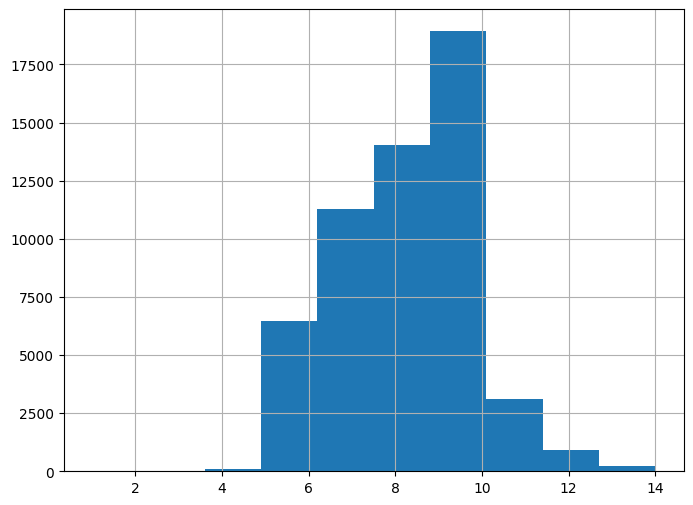

In [37]:
df_news["short_num_words"].hist(bins=10, figsize=(8,6))

<Axes: >

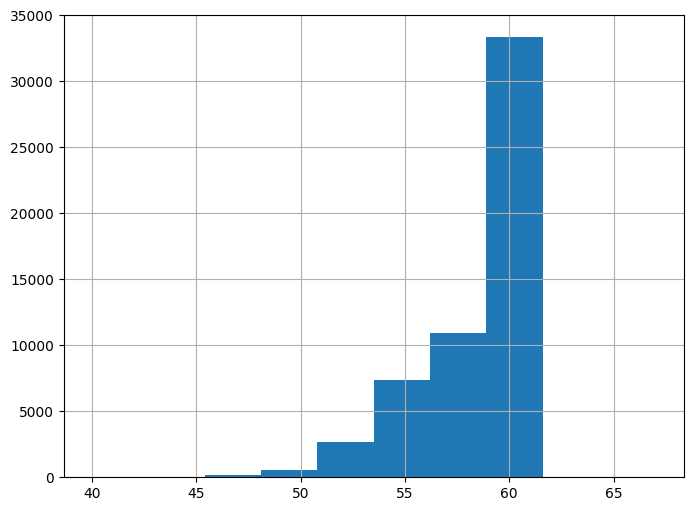

In [38]:
df_news["long_num_words"].hist(bins=10, figsize=(8,6))

In [39]:
(train_start,train_size) = (35000,20000)
(val_start,val_size) = (20000,15000)
(test_start,test_size) = (10000,10000)

train_end = train_start + train_size
val_end = val_start + val_size
test_end = test_start + test_size

train_texts, train_labels = list(df_news['long'][train_start:train_end]), list(df_news['short'][train_start:train_end])
val_texts, val_labels = list(df_news['long'][val_start:val_end]), list(df_news['short'][val_start:val_end])
test_texts, test_labels = list(df_news['long'][test_start:test_end]), list(df_news['short'][test_start:test_end])

In [40]:
torch.cuda.empty_cache()
gc.collect()

197

In [41]:
# use Pegasus model as base for fine-tuning
model_name = 'google/pegasus-xsum'
# pretrain_dir = '/content/drive/MyDrive/ML_project/pretrained/'
pretrain_dir = '/content/drive/MyDrive/ML_project/pretrained_2'


In [42]:
# train_dataset, val_dataset, test_dataset, tokenizer = prepare_data(model_name, train_texts, train_labels, val_texts, val_labels, test_texts, test_labels)
# # trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset, val_dataset, output_dir=pretrain_dir)
# trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset, output_dir=pretrain_dir)

In [43]:
# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# tokenizer = PegasusTokenizer.from_pretrained(pretrain_dir)
# model = PegasusForConditionalGeneration.from_pretrained(pretrain_dir).to(torch_device)

In [44]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [45]:
# train_dataset, val_dataset, test_dataset, tokenizer = prepare_data(model_name, train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, tokenizer=tokenizer)
# trainer = prepare_fine_tuning(model_name, tokenizer, train_dataset, model=model, output_dir=pretrain_dir)

In [46]:
torch.cuda.empty_cache()
gc.collect()

112

In [47]:
# trainer.train()
# trainer.train('/content/drive/MyDrive/ML_project/pretrained/checkpoint-2000')

In [48]:
# torch.cuda.empty_cache()
# gc.collect()

In [49]:
# pretrain_dir = '/content/drive/MyDrive/ML_project/pretrained_2'
# pretrain_dir = '/content/drive/MyDrive/ML_project/pretrained/checkpoint-2000'

In [50]:
# trainer.save_model(pretrain_dir)

In [51]:
# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# tokenizer = trainer.tokenizer
# model = trainer.model.to(torch_device)

# tokenizer = PegasusTokenizer.from_pretrained(pretrain_dir)
# model = PegasusForConditionalGeneration.from_pretrained(pretrain_dir).to(torch_device)

In [52]:
def get_summary(text):
  torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
  tokens = tokenizer(text, truncation=True, padding="longest", return_tensors="pt").to(torch_device)
  summary = model.generate(**tokens)
  pred_summary = tokenizer.decode(summary[0])
  return pred_summary

In [53]:
# metrics = []
# for text,label in tzip(test_texts[:1000],test_labels[:1000]):
#   # print(type(label))
#   metrics.append(compute_metrics([get_summary(text)],[label]))

In [54]:
# data_len = len(metrics)

# r1f1 = sum([item['rouge1_fmeasure'] for item in metrics]) / data_len
# r1pr = sum([item['rouge1_precision'] for item in metrics]) / data_len
# r1rc = sum([item['rouge1_recall'] for item in metrics]) / data_len

# r2f1 = sum([item['rouge2_fmeasure'] for item in metrics]) / data_len
# r2pr = sum([item['rouge2_precision'] for item in metrics]) / data_len
# r2rc = sum([item['rouge2_recall'] for item in metrics]) / data_len

# rLf1 = sum([item['rougeL_fmeasure'] for item in metrics]) / data_len
# rLpr = sum([item['rougeL_precision'] for item in metrics]) / data_len
# rLrc = sum([item['rougeL_recall'] for item in metrics]) / data_len

In [55]:
# print(r1f1, r1pr, r1rc)
# print(r2f1, r2pr, r2rc)
# print(rLf1, rLpr, rLrc)

In [56]:
idx = 54321

text = df_news_raw['long'][idx]
ref_summary = df_news_raw['short'][idx]
pred_summary = get_summary(text)

print(text)
print(ref_summary)
print(pred_summary)

Sweden capital, Stockholm will reportedly become the world’s first city to get 5G network by 2018. Swedish telecommunications giant Ericsson and Swedish-Finnish telecom operator TeliaSonera announced on Thursday that they will jointly launch the 5G network in Stockholm and Estonia's capital Tallinn. Notably, Ericsson along with TeliaSonera was the first to launch commercial 4G network in 2009.
Stockholm to get world's first 5G network
<pad>Ericsson and TeliaSonera have announced that they will jointly launch 5G network in Stockholm and Estonia.</s>


In [57]:
preds = []
refs = []

In [58]:
preds.append(pred_summary)
refs.append(ref_summary)

In [59]:
compute_metrics(preds, refs)

{'rouge1_precision': 0.2222,
 'rouge1_recall': 0.5,
 'rouge1_fmeasure': 0.3077,
 'rouge2_precision': 0.0588,
 'rouge2_recall': 0.1429,
 'rouge2_fmeasure': 0.0833,
 'rougeL_precision': 0.1111,
 'rougeL_recall': 0.25,
 'rougeL_fmeasure': 0.1538}

In [60]:
# idx = 31212

# text = df_news_raw['long'][idx]
# ref_summary = df_news_raw['short'][idx]
# pred_summary = get_summary(text)

# print(text)
# print(ref_summary)
# print(pred_summary)

In [61]:
# compute_metrics_from_text(decoded_preds=preds, decoded_labels=refs)

In [62]:
# text = '''
# According to the Guinness World Records, the most generations alive in a single family have been seven.  The difference between the oldest and the youngest person in the family was about 109 years, when Augusta Bunge&#39;s great-great-great-great grandson was born on January 21, 1989. The family belonged to the United States of America.
# '''
# get_summary(text)

In [63]:
def plot_run_info(run_data):
  run_data = run_data.replace('\n',' ')
  run_data = run_data.replace('\t',' ')
  run_data_list = [float(s) for s in run_data.split()]
  x_list = run_data_list[::2]
  y_list = run_data_list[1::2]
  plt.plot(x_list, y_list)

In [64]:
run_data1 = '''
50	8.376900
100	7.375400
150	7.295200
200	6.878300
250	6.843700
300	6.617700
350	6.257500
400	6.012200
450	5.132100
500	3.257100
550	1.584900
600	1.707600
650	1.633400
700	1.532100
750	1.332500
800	1.517700
850	1.418800
900	1.385800
950	1.464000
1000	1.409000
1050	1.242500
1100	1.464100
1150	1.377000
1200	1.316900
1250	1.472900
1300	1.411900
1350	1.293700
1400	1.425000
1450	1.373600
1500	1.378500
1550	1.251500
1600	1.240300
1650	1.311600
1700	1.204400
1750	1.341100
1800	1.262200
1850	1.261700
1900	1.166300
1950	1.121600
2000	1.276900
2050	1.294300
2100	1.250800
2150	1.269300
2200	1.161100
2250	1.240600
2300	1.269000
2350	1.092800
2400	1.110900
2450	1.297500
2500	1.206900
2550	1.223100
2600	1.146800
2650	1.149800
2700	1.239100
2750	1.126800
2800	1.034000
2850	1.230300
2900	1.186400
2950	1.155500
3000	1.249100
3050	1.136300
3100	1.082400
3150	1.264100
3200	1.149800
3250	1.201900
3300	1.215000
3350	1.162100
3400	1.189900
3450	1.029900
3500	1.216600
3550	1.111700
3600	1.108500
3650	1.140500
3700	1.186100
3750	1.034400
3800	1.086000
3850	1.230600
3900	1.142300
3950	1.214900
4000	1.090100
4050	1.201800
4100	1.229400
4150	1.033700
4200	1.016800
4250	1.045000
4300	1.018400
4350	1.034500
4400	1.063000
4450	1.061100
4500	1.041100
4550	1.164800
4600	1.167800
4650	1.098100
4700	1.018600
4750	1.145900
4800	1.117900
4850	1.093700
4900	1.019900
4950	1.107500
5000	1.187500
5050	1.065300
5100	1.050900
5150	1.065800
5200	1.142400
5250	0.957600
5300	1.213300
5350	1.005000
5400	1.138900
5450	1.062200
5500	1.082200
5550	1.174400
5600	1.032200
5650	1.066000
5700	1.156400
5750	0.909900
5800	1.075900
5850	1.062500
5900	1.120000
5950	1.067900
6000	1.079500
6050	1.210800
6100	1.094000
6150	0.988900
6200	1.181300
6250	1.059300
6300	1.181000
6350	1.101000
6400	1.156500
6450	1.011100
6500	1.056900
6550	1.176700
6600	1.079300
6650	0.952600
6700	1.044300
6750	1.050600
6800	1.084200
6850	1.118600
6900	1.047300
6950	0.996900
7000	1.071500
7050	1.007500
7100	0.996200
7150	1.248500
7200	1.043100
7250	1.051600
7300	0.957900
7350	1.043800
7400	0.967200
7450	0.887200
7500	0.905600
7550	1.033000
7600	1.046000
7650	1.065200
7700	0.961500
7750	0.978900
7800	1.040200
7850	1.095800
7900	1.077200
7950	0.947800
8000	1.050800
8050	1.002400
8100	1.003000
8150	0.791900
8200	1.016300
8250	1.054400
8300	0.928100
8350	0.849000
8400	1.015600
8450	0.995900
8500	1.013300
8550	1.069700
8600	1.022900
8650	0.976100
8700	1.016600
8750	0.933300
8800	1.160700
8850	0.950200
8900	0.897500
8950	0.974300
9000	1.000000
9050	1.134100
9100	1.099300
9150	0.889100
9200	0.866400
9250	1.113400
9300	1.073800
9350	1.025500
9400	0.916600
9450	1.045700
9500	0.955900
9550	1.077000
9600	1.039400
9650	1.010700
9700	1.046100
9750	1.036200
9800	1.059200
9850	0.996300
9900	0.873700
9950	0.982000
10000	0.925100
10050	1.167500
10100	0.970600
10150	1.133600
'''

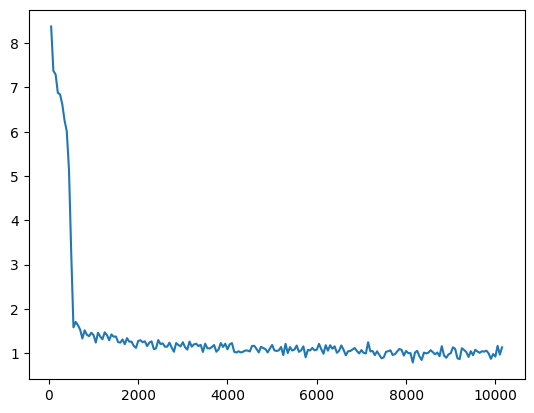

In [65]:
plot_run_info(run_data1)